<h1>Introduction to Text Analytics - Homework 1<span class="tocSkip"></span></h1>

Using NLTK to analyse news articles from a corpus, including:
* Reading, Cleaning and Transforming the Corpus (parts 1-2)
* Summary Statistical Analysis of the Texts' Tokens (parts 3-6)
* N-Gram Analysis (part 7)
* Topic Modelling (parts 8-10)

Import all of the required modules.

In [1]:
import bs4
import collections
import math
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import wordnet
import numpy as np
import os
import pandas as pd
import requests
import sklearn
import string
import wordcloud as wc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

## Gather Data into Data Frame

The very first thing we need to do before we can analyse our data is to gather the data from the input files and enter it into a Pandas DataFrame.

### Read Documents Into a Data Frame

We read the CSV files into a Pandas DataFrame object so we can easily analyse the data.

In [2]:
DATA_DIRECTORY = "./data/"
OUTPUT_DIRECTORY = "./output/"

# Lambda function to convert a file name to the output path that it should be saved to.
output = lambda filename: OUTPUT_DIRECTORY + filename

In [3]:
raw_data = pd.DataFrame([], columns=['id', 'title', 'content'])

for filename in os.listdir(DATA_DIRECTORY):
    # Only read files in the correct format.
    if not filename.endswith('.txt'):
        continue
        
    filepath = os.path.join(DATA_DIRECTORY, filename)
    
    # Note: we use UTF-8 here so that the currency symbols are read in correctly.
    file = open(filepath, encoding="utf8")
    
    # The filename without the ".txt" extension at the end, converted to an integer.
    file_id = int(filename[0:-4])
    
    # Get the text data from the file.
    text_data = file.read()
    
    # Split the file into title and content attributes.
    line_splits = text_data.split("\n")
    title = line_splits[0]
    content = "\n".join(line_splits[1:])

    # Dictionary containing the attributes extracted from the file.
    file_data = {'id': file_id, 'title': title, 'content': content}

    # Add this file's data to the data frame.
    raw_data = raw_data.append(file_data, ignore_index=True)    
        
raw_data.head()

id                             title  \
0   0  China net cafe culture crackdown   
1   1  Mobile networks seek turbo boost   
2  10   Sony wares win innovation award   
3  11  Portable PlayStation ready to go   
4  12    BT offers free net phone calls   

                                             content  
0  \nChinese authorities closed 12,575 net cafes ...  
1  \nThird-generation mobile (3G) networks need t...  
2  \nSony has taken the prize for top innovator a...  
3  \nSony's PlayStation Portable (PSP) will go on...  
4  \nBT is offering customers free internet telep...

We order the dataframe by the articles' id attribute. Since the id attribute is a unique identifier for each article, we will use it as the index for our dataframe.

In [4]:
raw_data = raw_data.sort_values(by='id', ascending=True, na_position='first')
raw_data.set_index('id', inplace=True)

raw_data.head()

title  \
id                                      
0    China net cafe culture crackdown   
1    Mobile networks seek turbo boost   
2   UK gets official virus alert site   
3       US woman sues over cartridges   
4    T-Mobile bets on 'pocket office'   

                                              content  
id                                                     
0   \nChinese authorities closed 12,575 net cafes ...  
1   \nThird-generation mobile (3G) networks need t...  
2   \nA rapid alerting service that tells home com...  
3   \nA US woman is suing Hewlett Packard (HP), sa...  
4   \nT-Mobile has launched its latest "pocket off...

### Save Data Frame to CSV File

Now that we have read the data into our dataframe, we will need a way to export the data. To do this, we write the dataframe to a CSV (comma-separated values) file.

In [5]:
raw_data.to_csv(output("H1_raw_data.csv"), sep=',', index=None)

We then read our data from the file we just wrote to, in order to ensure that it was written to correctly.

In [6]:
# Check that the raw data was saved to a CSV correctly and that we can read it in again.
reread_data = pd.read_csv(output("H1_raw_data.csv"))
dataframes_equal = reread_data.equals(raw_data)

print("The dataframes are equivalent is: {}.".format(str(dataframes_equal).lower()))

The dataframes are equivalent is: false.


We have now successfully loaded our corpus into a data frame. 
Now we can do some cleaning and pre-processing steps on the data contained within.

## Extract Tokens From Raw Text

Now that we have our data, we want to process it. However, textual data is unstructured. This means that it can come in many different forms. We will have to develop a process by which to normalize the text so that the algorithms that we apply to each document will treat each document equally.


To do this, we will split each document's textual content into a list of words, called tokens. This process is called *tokenization*. After tokenizing, we will perform some data cleaning and transformation (like removing special characters and converting every word to lowercase, etc.)

We define each of our transformation functions individually. We also define a function, `normalize_text()`, that performs all of the transformation functions on a dataframe series.

We have the individual functions so that we can go through and discuss them one-by-one in this section. In later sections, however, we will use the conglomerate function for brevity.

### Transformation Functions

Firstly, we define some utility functions that are needed by the transformation functions.

In [7]:
def get_stop_words():
    """
    Returns a list of stopwords that should be removed when preprocessing text.
    Included are nltk stopwords, salutations and a list of stopwords shown in the labs.
    """
    stop_words = nltk.corpus.stopwords.words('english')
    
    # Add salutations to the stop words list.
    salutations = ['mr','mrs','mss','dr','phd','prof','rev']
    stop_words.extend(salutations)
        
    additional_stop_words = ["a","a's","able","about","above","according","accordingly","across","actually","after","afterwards","again","against","ain't","all","allow","allows","almost","alone","along","already","also","although","always","am","among","amongst","an","and","another","any","anybody","anyhow","anyone","anything","anyway","anyways","anywhere","apart","appear","appreciate","appropriate","are","aren't","around","as","aside","ask","asking","associated","at","available","away","awfully","b","be","became","because","become","becomes","becoming","been","before","beforehand","behind","being","believe","below","beside","besides","best","better","between","beyond","both","brief","but","by","c","c'mon","c's","came","can","can't","cannot","cant","cause","causes","certain","certainly","changes","clearly","co","com","come","comes","concerning","consequently","consider","considering","contain","containing","contains","corresponding","could","couldn't","course","currently","d","definitely","described","despite","did","didn't","different","do","does","doesn't","doing","don't","done","down","downwards","during","e","each","edu","eg","eight","either","else","elsewhere","enough","entirely","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","exactly","example","except","f","far","few","fifth","first","five","followed","following","follows","for","former","formerly","forth","four","from","further","furthermore","g","get","gets","getting","given","gives","go","goes","going","gone","got","gotten","greetings","h","had","hadn't","happens","hardly","has","hasn't","have","haven't","having","he","he's","hello","help","hence","her","here","here's","hereafter","hereby","herein","hereupon","hers","herself","hi","him","himself","his","hither","hopefully","how","howbeit","however","i","i'd","i'll","i'm","i've","ie","if","ignored","immediate","in","inasmuch","inc","indeed","indicate","indicated","indicates","inner","insofar","instead","into","inward","is","isn't","it","it'd","it'll","it's","its","itself","j","just","k","keep","keeps","kept","know","known","knows","l","last","lately","later","latter","latterly","least","less","lest","let","let's","like","liked","likely","little","look","looking","looks","ltd","m","mainly","many","may","maybe","me","mean","meanwhile","merely","might","more","moreover","most","mostly","much","must","my","myself","n","name","namely","nd","near","nearly","necessary","need","needs","neither","never","nevertheless","new","next","nine","no","nobody","non","none","noone","nor","normally","not","nothing","novel","now","nowhere","o","obviously","of","off","often","oh","ok","okay","old","on","once","one","ones","only","onto","or","other","others","otherwise","ought","our","ours","ourselves","out","outside","over","overall","own","p","particular","particularly","per","perhaps","placed","please","plus","possible","presumably","probably","provides","q","que","quite","qv","r","rather","rd","re","really","reasonably","regarding","regardless","regards","relatively","respectively","right","s","said","same","saw","say","saying","says","second","secondly","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sensible","sent","serious","seriously","seven","several","shall","she","should","shouldn't","since","six","so","some","somebody","somehow","someone","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specified","specify","specifying","still","sub","such","sup","sure","t","t's","take","taken","tell","tends","th","than","thank","thanks","thanx","that","that's","thats","the","their","theirs","them","themselves","then","thence","there","there's","thereafter","thereby","therefore","therein","theres","thereupon","these","they","they'd","they'll","they're","they've","think","third","this","thorough","thoroughly","those","though","three","through","throughout","thru","thus","to","together","too","took","toward","towards","tried","tries","truly","try","trying","twice","two","u","un","under","unfortunately","unless","unlikely","until","unto","up","upon","us","use","used","useful","uses","using","usually","uucp","v","value","various","very","via","viz","vs","w","want","wants","was","wasn't","way","we","we'd","we'll","we're","we've","welcome","well","went","were","weren't","what","what's","whatever","when","whence","whenever","where","where's","whereafter","whereas","whereby","wherein","whereupon","wherever","whether","which","while","whither","who","who's","whoever","whole","whom","whose","why","will","willing","wish","with","within","without","won't","wonder","would","wouldn't","x","y","yes","yet","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","z","zero"]
    stop_words.extend(additional_stop_words)
    
    return stop_words


def pos_to_wordnet_tag(pos_tag):
    """
    Convert an NLTK.pos_tag to a WordNet tag that the lemmatizer uses.
    """
    if pos_tag.lower().startswith('j'):
        return 'a'
    elif pos_tag.lower().startswith('v'):
        return 'v'
    elif pos_tag.lower().startswith('n'):
        return 'n'
    elif pos_tag.lower().startswith('r'):
        return 'r'
    else:
        # Default POS for lemmatization is noun.
        return 'n'

Now we define the transformation functions themselves.

In [8]:
def convert_hyphens(series):
    """
    Takes a string of text and returns a string of text with hyphens replaced by underscores.
    We do this so words like "e-mail", "wi-fi", etc. are kept together.
    """
    return series.replace("-", "_")


def tokenize(series):
    """
    Takes a string of text and returns a list of string tokens.
    """
    # Pattern matches one or more alphanumeric characters (or underscores).
    TOKENIZER_REGEX = r'\w+'
    tokenizer = nltk.tokenize.RegexpTokenizer(TOKENIZER_REGEX)  
    return tokenizer.tokenize(series)


def decapitalize(series):
    """
    Takes a list of tokens and returns a list of tokens, with every token in lowercase form.
    """
    # Map the string to-lowercase method to every value in the series.
    return [word.lower() for word in series]


def remove_numbers(series):
    """
    Takes a list of tokens and returns a list of tokens that do not consist solely of numeric characters.
    For example, "3" is removed, but not "3G" or "Three".
    """
    return [word for word in series if not word.isnumeric()]


def remove_special_chars(series):
    """
    Takes a list of tokens and returns that list, without special characters.
    
    The only special characters that are left in the text are underscores since we used
    the regex '\w+'. We can remove them safely since words like 'wi-fi' (which would have 
    been converted to 'wi_fi') can equally be represented as 'wifi' (with no underscore).
    
    However, for completeness, we strip all punctuation characters from each word. We then only
    include the word in the resultant list of words if the word has not been reduced to an empty string.
    """    
    words_to_remove = set(["", "_"])
    return [word.replace("_", "") for word in series if word not in words_to_remove]


def remove_punctuation(series):
    """ 
    Takes a list of tokens and returns a list of tokens, with any punctuation stripped.
    
    This is not included in the normalize_text() function since it is not needed - the
    punctuation is removed in the tokenize() function anyway. However, it is included 
    here for completeness and is used in the n-gram analysis later.
    """
    results = []
    
    for word in series:
        new_word = "".join(character for character in word if character not in string.punctuation)
        
        if new_word is not "":
            results.append(new_word)
    
    return results


def remove_stop_words(series):
    """
    Takes a list of tokens and returns a list of those tokens that are not contained 
    in the stop words list.
    """
    return [word for word in series if word not in get_stop_words()]
    
    
def lemmatize(series):   
    """
    Takes a list of tokens and returns a list of the same tokens, transformed using the 
    WordNet Lemmatizer. This lemmatization process converts words into a common root.
    For example, it converts plural words into singular form, or past-tense verbs into their root.
    """
    lemmatizer = nltk.stem.WordNetLemmatizer()
    
    lemmatized_words = []
    for word, tag in nltk.pos_tag(series):
        wordnet_tag = pos_to_wordnet_tag(tag)
        lemmatized_words.extend([lemmatizer.lemmatize(word, wordnet_tag)])
        
    return lemmatized_words


def normalize_text(series, keep_stop_words=False, lemmatization=True):
    """ 
    Takes a pandas Series object and returns a list of tokens for that series.
    Gives an option (default=True) on whether to do lemmatization or not.
    """
    newseries = (series.apply(convert_hyphens)
                  .apply(tokenize)
                  .apply(remove_special_chars)
                  .apply(decapitalize)
                  .apply(remove_numbers))
    
    if lemmatization:
        newseries = newseries.apply(lemmatize)
    
    if not keep_stop_words:
        newseries = newseries.apply(remove_stop_words)

    return newseries

We now go through applying each transformation function step-by-step.

#### Tokenization

Our first step is to tokenize the words in the text of each article. We will create a new column in our dataframe and call it `tokens`, filling it with the result of applying our `tokenize()` function on the `contents` column.

We define a token using the regular expression `\w+`, which matches any alphanumeric character or an underscore, "_". Because we don't match the hypen character, "-", we need to convert hyphens to underscores before tokenizing. This ensures that words like "wi-fi" are not divided into two separate words.

In [9]:
raw_data['tokens'] = raw_data['content'].apply(convert_hyphens).apply(tokenize)
raw_data.head()

title  \
id                                      
0    China net cafe culture crackdown   
1    Mobile networks seek turbo boost   
2   UK gets official virus alert site   
3       US woman sues over cartridges   
4    T-Mobile bets on 'pocket office'   

                                              content  \
id                                                      
0   \nChinese authorities closed 12,575 net cafes ...   
1   \nThird-generation mobile (3G) networks need t...   
2   \nA rapid alerting service that tells home com...   
3   \nA US woman is suing Hewlett Packard (HP), sa...   
4   \nT-Mobile has launched its latest "pocket off...   

                                               tokens  
id                                                     
0   [Chinese, authorities, closed, 12, 575, net, c...  
1   [Third_generation, mobile, 3G, networks, need,...  
2   [A, rapid, alerting, service, that, tells, hom...  
3   [A, US, woman, is, suing, Hewlett, Packard, HP...  
4   [T_Mobile, has, launched, its, latest, pocket,...

We see that we have successsfully split the `content` column into its component words. Notice that the word 'T-Mobile' has been kept as one word "T_Mobile" rather than being split into two.

However, we actually ran into an issue with the conversion of hyphens to underscores. Where hyphens were on their own, for example, when used as a grammatical construct they are not removed; they were converted to words of one character, a single underscore.

For example:

In [10]:
print(raw_data['content'].iloc[1][520:590])
print(raw_data['tokens'].iloc[1][87:101])

one gigabit a second - up to 20 times faster than current 3G networks.
['one', 'gigabit', 'a', 'second', '_', 'up', 'to', '20', 'times', 'faster', 'than', 'current', '3G', 'networks']


The hyphen not between words, called an *em-dash*, should be removed. We do this in our next step.

#### Remove Punctuation and Special Characters

Because of the regex pattern that we used, `\w+`, we have already separated tokens into only alphanumeric words. This means that we don't have to do any further filtering to remove punctuation and special characters.

However, the `\w+` pattern also includes underscores, so we remove them now. We also remove any tokens that are just empty strings.

In [11]:
raw_data['tokens'] = raw_data['tokens'].apply(remove_special_chars)
raw_data['tokens'].head()

id
0    [Chinese, authorities, closed, 12, 575, net, c...
1    [Thirdgeneration, mobile, 3G, networks, need, ...
2    [A, rapid, alerting, service, that, tells, hom...
3    [A, US, woman, is, suing, Hewlett, Packard, HP...
4    [TMobile, has, launched, its, latest, pocket, ...
Name: tokens, dtype: object

Notice that the "_" token is now removed.

In [12]:
print(raw_data['content'].iloc[1][520:590])
print(raw_data['tokens'].iloc[1][87:101])

one gigabit a second - up to 20 times faster than current 3G networks.
['one', 'gigabit', 'a', 'second', 'up', 'to', '20', 'times', 'faster', 'than', 'current', '3G', 'networks', 'The']


#### Decapitalization

Our data is still not fully normalized though. We want all tokens to have the same form, but some of the tokens are uppercase, some lowercase, and some a mixture of both. To ensure consistency in our data, we are going to convert every token into its lowercase form.

In [13]:
raw_data['tokens'] = raw_data['tokens'].apply(decapitalize)
raw_data['tokens'].head()

id
0    [chinese, authorities, closed, 12, 575, net, c...
1    [thirdgeneration, mobile, 3g, networks, need, ...
2    [a, rapid, alerting, service, that, tells, hom...
3    [a, us, woman, is, suing, hewlett, packard, hp...
4    [tmobile, has, launched, its, latest, pocket, ...
Name: tokens, dtype: object

#### Remove Numbers

We can see that some of our tokens are just numeric strings, which we want to remove.

Note that we will not remove tokens that contain both letters and numbers. For example, "3g" considered a word and it would lose its meaning if it were changed to just "g".

In [14]:
raw_data['tokens'] = raw_data['tokens'].apply(remove_numbers)
raw_data['tokens'].head()

id
0    [chinese, authorities, closed, net, cafes, in,...
1    [thirdgeneration, mobile, 3g, networks, need, ...
2    [a, rapid, alerting, service, that, tells, hom...
3    [a, us, woman, is, suing, hewlett, packard, hp...
4    [tmobile, has, launched, its, latest, pocket, ...
Name: tokens, dtype: object

#### Lemmatization

Consider the first document. We have tokens like "authorities" and "cafes" - they are plural nouns. However, if we want to count the occurrences of these tokens, they should not be considered as different words to their singular counterparts. 

In [15]:
first_article = raw_data.tokens.iloc[0].copy()

In [16]:
count_cafes = first_article.count("cafes")
count_cafe = first_article.count("cafe")

print("Count of 'cafes' = {}".format(count_cafes))
print("Count of 'cafe'  = {}".format(count_cafe))

Count of 'cafes' = 11
Count of 'cafe'  = 2


We perform an operation known as *lemmatization*, which takes a word and alters it to its root form. For example, it will convert plural nouns to singular nouns, or convert past-tense verbs to the radical form.

In [17]:
raw_data['tokens'] = raw_data['tokens'].apply(lemmatize)
raw_data['tokens'].head()

id
0    [chinese, authority, close, net, cafe, in, the...
1    [thirdgeneration, mobile, 3g, network, need, t...
2    [a, rapid, alerting, service, that, tell, home...
3    [a, u, woman, be, sue, hewlett, packard, hp, s...
4    [tmobile, have, launch, it, late, pocket, offi...
Name: tokens, dtype: object

We look to see if this has amalgamated the words 'cafe' and 'cafes':

In [18]:
count_cafe = raw_data['tokens'].iloc[0].count("cafe")
print("Count of 'cafe'  = {}".format(count_cafe))

Count of 'cafe'  = 13


It has, so our lemmatization has been successful.

#### Remove Stop Words

We have now cleaned up our tokens so that they only contain real words and in lemmatized form. However, some words are not as valuable as others. For example, if we want to calculate the most-common word in an article, it is likely that it will be a word like 'a', 'the', etc. These words are called *stop words*, they do not gives us valuable information since they are so prevalent in the English language. So we decide that we are going to remove them from our list of tokens.

In [19]:
raw_data['tokens'] = raw_data['tokens'].apply(remove_stop_words)
raw_data['tokens'].head()

id
0    [chinese, authority, close, net, cafe, closing...
1    [thirdgeneration, mobile, 3g, network, fast, d...
2    [rapid, alerting, service, home, computer, use...
3    [woman, sue, hewlett, packard, hp, printer, in...
4    [tmobile, launch, late, pocket, office, thirdg...
Name: tokens, dtype: object

### Tests
#### Test Cleaned Data

It is very important that we run tests to ensure our data is as we expect it to be. Failing to carry out tests can lead to problems in analysis furter on.

We define and run a test now to ensure that our data has been tokenized successfully and those tokens are cleaned and normalized as we expect.

In [20]:
def columnIsClean(series):
    return all([tokensAreClean(tokens) for tokens in series])
   

def tokensAreClean(tokens):    
    if any([token.isupper() for token in tokens]):
        print("Some tokens are not uppercase")
        return False
    
    elif any([not token.isalnum() for token in tokens]):
        print("Some tokens contain special (non-alphanumeric) characters")
        return False
    
    elif any([token.isnumeric() for token in tokens]):
        print("Some tokens are numeric")
        return False
    
    elif any([True for token in tokens if token in get_stop_words()]):
        print("Some stop words were not removed")
        return False
    
    else:
        # Data has been cleaned successfully.
        return True

In [21]:
data_cleaned_successfully = columnIsClean(raw_data['tokens'])

# Throw an error if test fails.
assert(data_cleaned_successfully)

if data_cleaned_successfully:
    print("Data Cleaned and Tokenized Successfully!")

Data Cleaned and Tokenized Successfully!


#### Do Tokenization in One Go

Now that we have shown that our data has been successfully cleaned, we also need to test that our function to do the normalization in one go (which we will use later) is equivalent to what we have done step by step. 

In [22]:
oldtokens = raw_data['tokens'].copy()
raw_data['tokens'] = normalize_text(raw_data['content'])

series_equal = oldtokens.equals(raw_data['tokens'])

# Throw an error if not equal.
assert(series_equal)

if series_equal:
    print("The one-by-one and all-at-once methods are equal!")

The one-by-one and all-at-once methods are equal!


Now, we move on to some analysis of our cleaned data.

## Create Word Cloud for all Tokens in Corpus

First, we make a function that creates and plots a word cloud from a list of tokens, using the `WordCloud` and `Matplotlib` packages. This helps with code reuse and clarity, since we will be creating a couple of word clouds.

We also create a function for gathering all of the tokens in the corpus into one list (using a nested-for list comprehension) since we will be using the function multiple times in this notebook.

In [23]:
def createAndPlotWordCloud(tokens):
    # The word cloud uses a sentence string not a list,
    # so we convert our tokens to a single string.
    tokens_string = " ".join(tokens)
    
    # Create the wordcloud object.
    wordcloud = wc.WordCloud(width=1600, height=800).generate(tokens_string)
    
    # Matplotlib settings.
    plt.figure(figsize=(20,10), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    
    return wordcloud


def getAllTokens(df):
    """
    Convert the tokens column in a dataframe into a list of strings of every 
    token in the tokens column.
    """
    return [token for tokens in df['tokens'] for token in tokens]

Create the wordcloud image and show it. We also save it to a file called *img_wordcloud.png*.

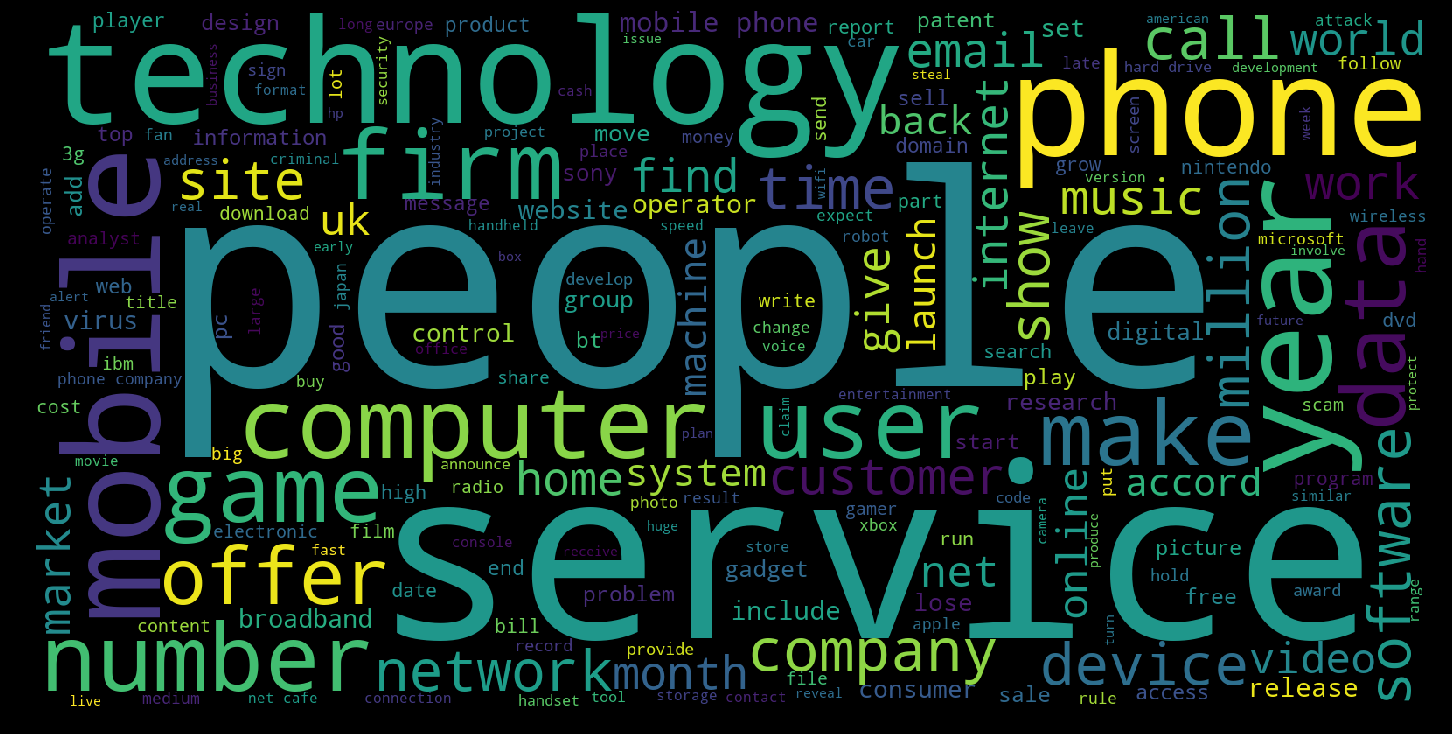

In [24]:
# Get all the tokens from our data.
all_tokens_list = getAllTokens(raw_data)

wordcloud = createAndPlotWordCloud(all_tokens_list)
wordcloud.to_file(output("img_wordcloud.png"))

# Delete this since it's a variable that will be used later.
del all_tokens_list

## Create Word Clouds for First Five Documents

We make the function calls to create each of the wordcloud in separate notebook cells. Note that since we did a loop in a single cell, you may have to use the scrollbars in order to see all of the worldclouds.

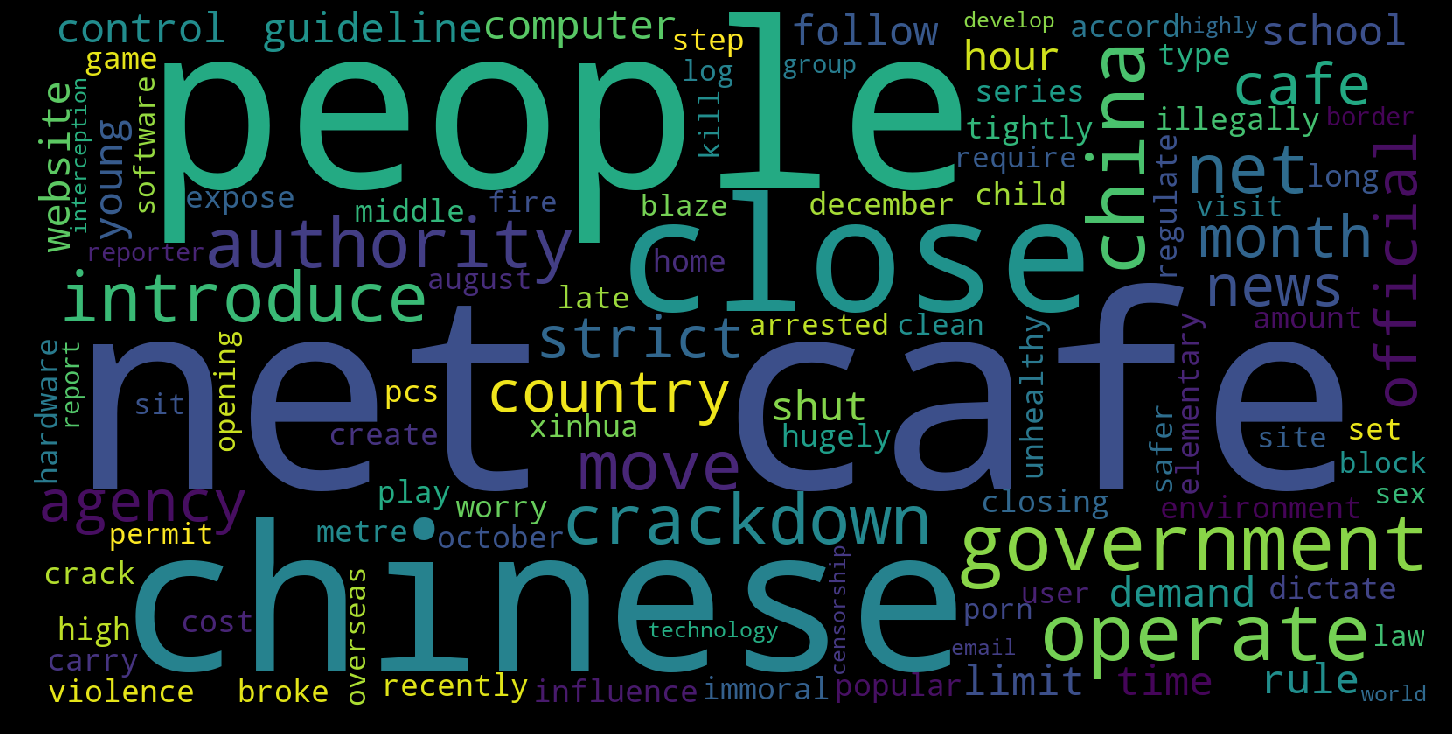

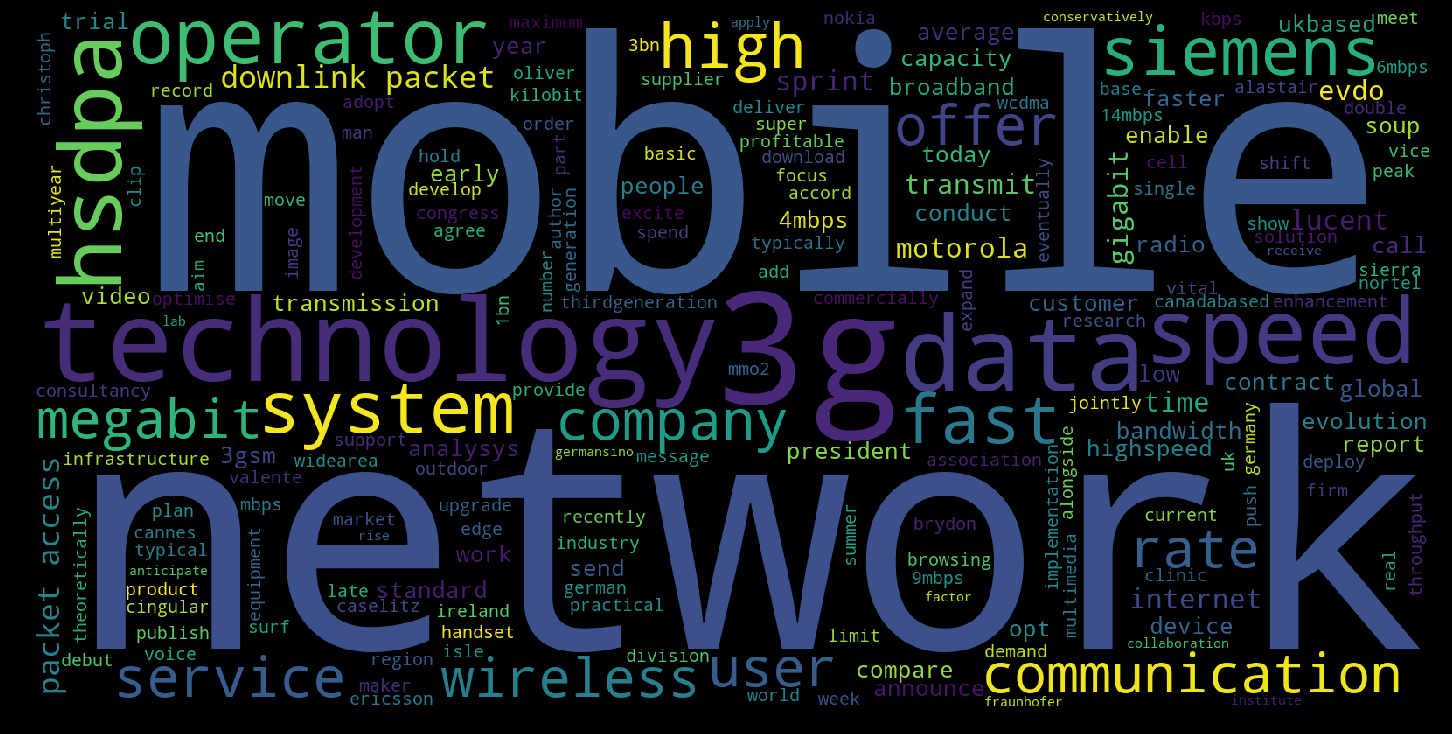

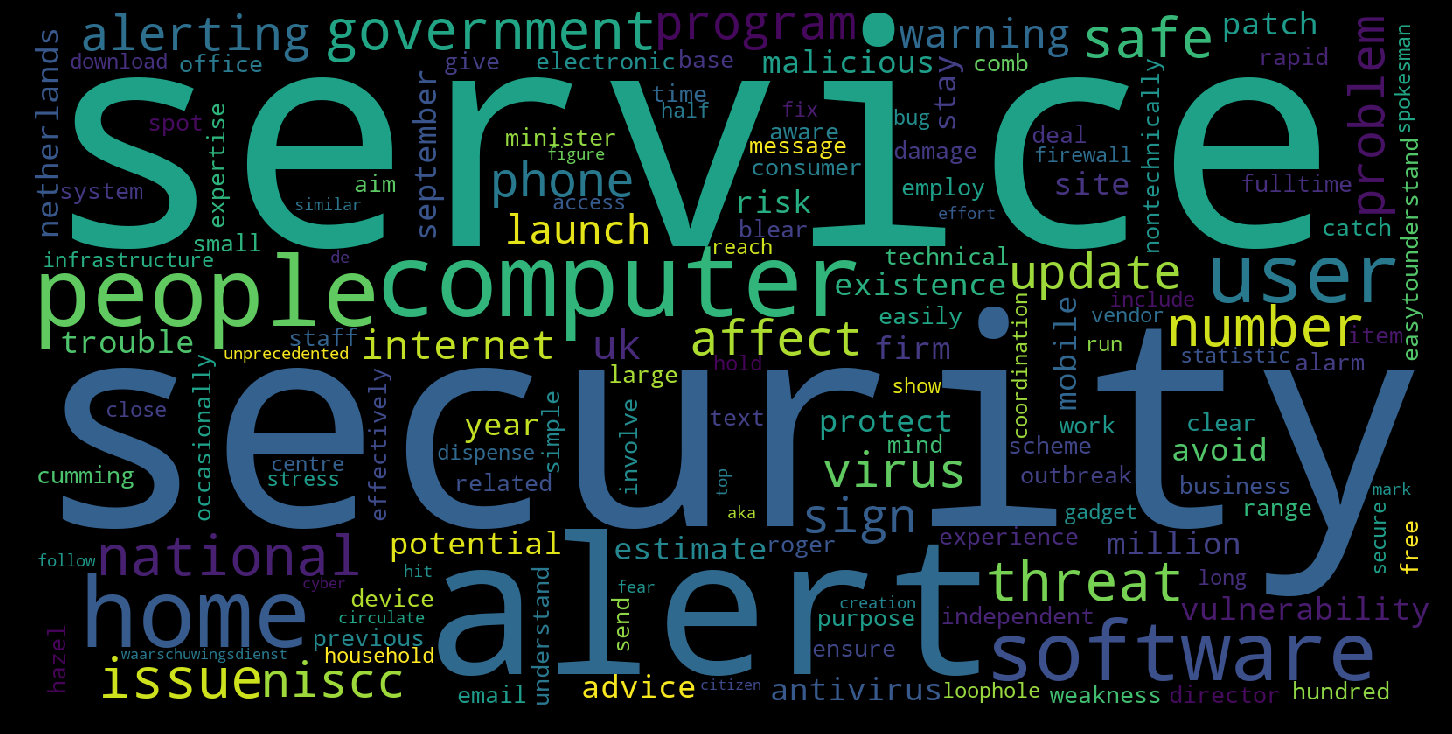

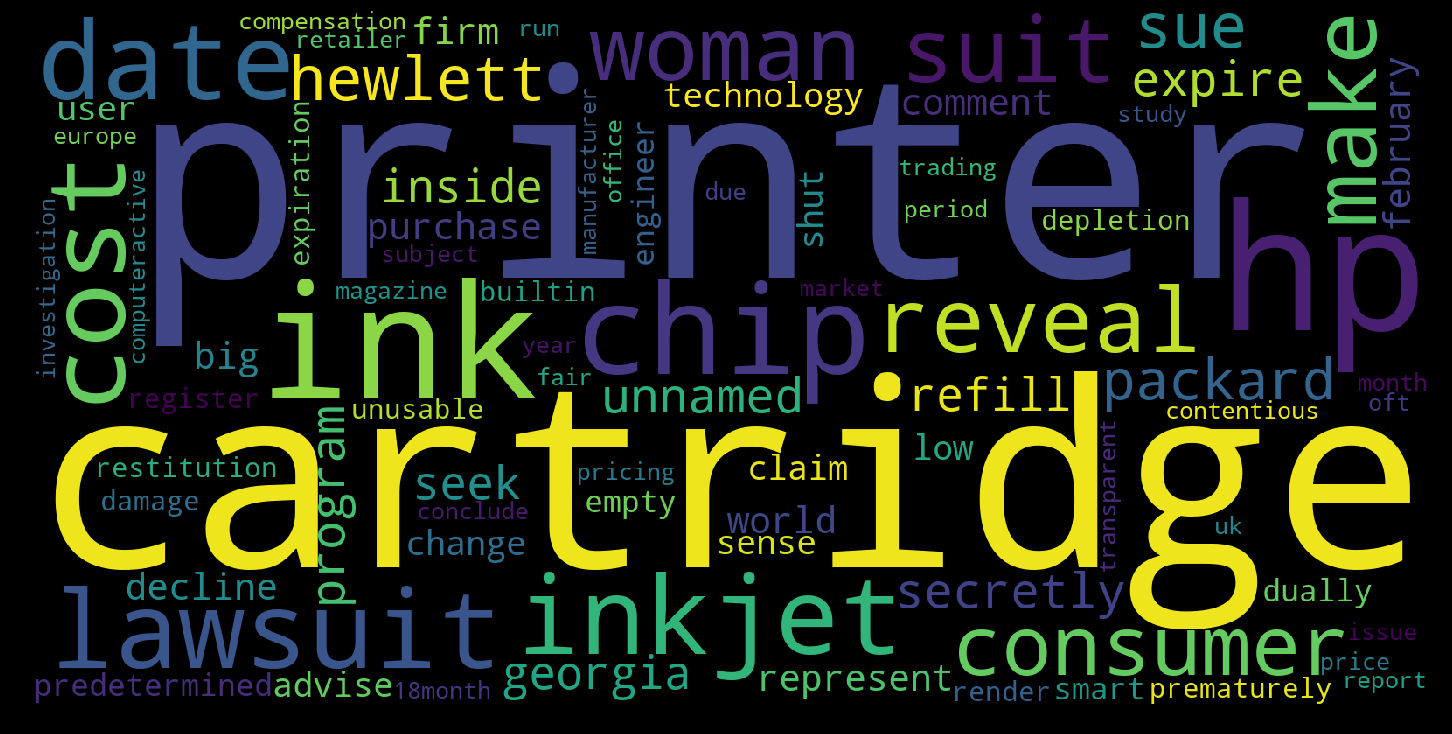

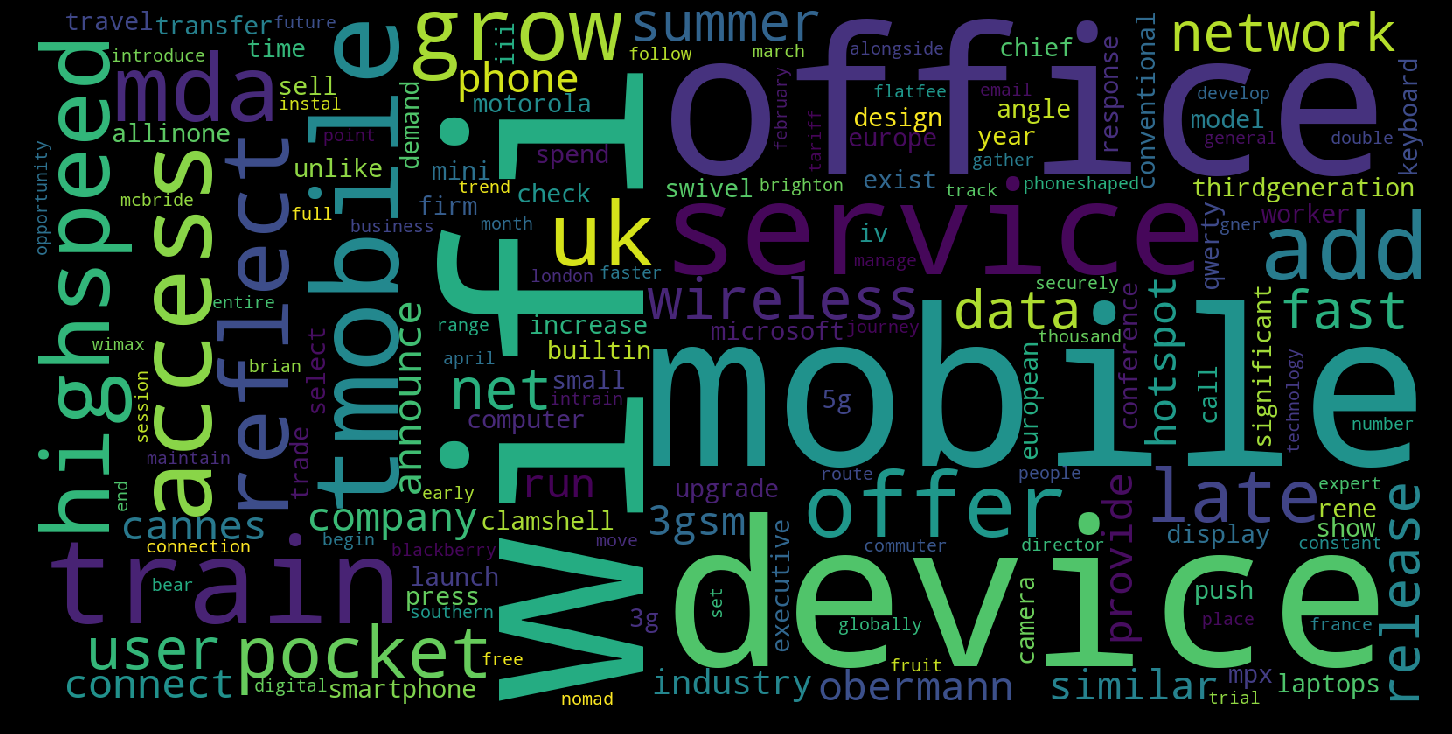

In [25]:
for i in range(5):
    createAndPlotWordCloud(raw_data.iloc[i]['tokens'])

We can see that most of these document are in some form related to technology. The most-prominent words are those that are the biggest in the word cloud (since they appear most-frequently in the article). They refer to "net cafes", "mobile networks", "service alerts", "printer cartridges" and "mobile wifi" - all strongly linked to the topic of technology.

We can also see that there are different distributions of the frequencies of words in each of the documents. For example, in the 5th article, there are a number of words that stand out in the word cloud (because ther are frequent), like "wifi", "mobile", "device" and "office". However, there are other words that are almost the same size as these biggest words. This is a rather even distribution, compared to the second document. In the 2nd document, by far the most prominent words are "mobile" and "network", which are massive compared to the other words in the wordcloud.

## Most-Common Words for Entire Corpus

Now, we want to look at the words that are most-frequent across the entire corpus of documents. We will use a `Counter` from the `collections` module to determine each token's frequency and then plot the top-ten most-common words using `Matplotlib`.

In [26]:
def frequencyDistToDataFrame(freq_dist, top_n):
    most_common_terms = []
    
    for term, count in freq_dist.most_common(top_n):
        most_common_terms.append({'term': term, 'count': count})
    
    most_common_df = pd.DataFrame(most_common_terms)
    most_common_df.sort_values(by='count', ascending=True, inplace=True)

    return most_common_df


def plotFrequencyDataFrame(df, title, xlabel="Frequency", ylabel="", fileName=None):
    """
    Plot a horizontal bar chart of the most common words in a given 
    dataframe, with columns 'term' and 'count'. The bars are sorted 
    so that the most-common word appears at the top.
    """
    fig, axis = plt.subplots()

    df.plot.barh(x='term', y='count', ax=axis)
    
    axis.set_title(title)
    axis.set_xlabel(xlabel)
    axis.set_ylabel(ylabel)

    # Save figure to an image file.
    if fileName is not None:
        plt.savefig(output(fileName))

    # This should only be executed after plt.savefig(),
    # otherwise the image saved will be blank.
    plt.show()

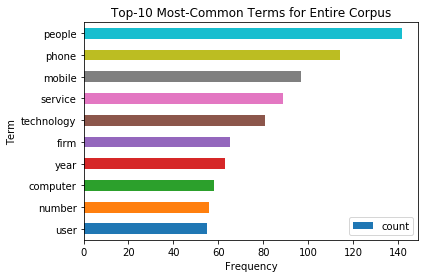

In [27]:
# Get all the tokens for the corpus in a list.
all_tokens_list = getAllTokens(raw_data)

# Get the frequency of each term in the corpus and create a DataFrame from it.
tokens_counter = collections.Counter(all_tokens_list)
most_common_df = frequencyDistToDataFrame(tokens_counter, 10)

plotFrequencyDataFrame(most_common_df, title="Top-10 Most-Common Terms for Entire Corpus",
                       ylabel="Term", fileName="img_top10_common.png")

# # Delete these to protect code reuse.
del most_common_df, all_tokens_list

Continuing with the trend that we saw emerging from the wordclouds of the first five documents, it seems that technology-based words are those that are most-common in the corpus.

## Top-10 Most-Common Words in each Document

Now, we look more in-depth at the most-common words within the corpus. Specifically, we look at the most-common words in each of the documents. We will plot the top-ten most-common words for the first five documents in a bar chart and print out a list of the top-ten most common words for each of the 51 documents.

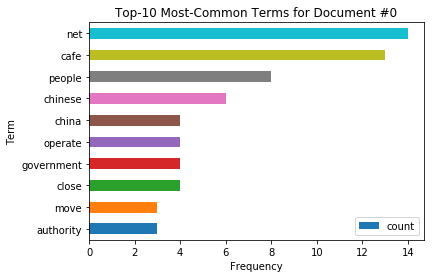

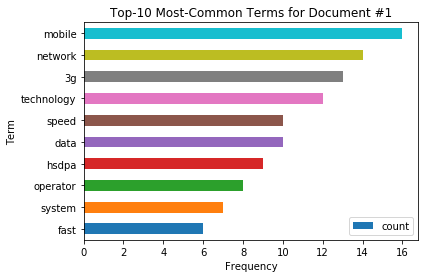

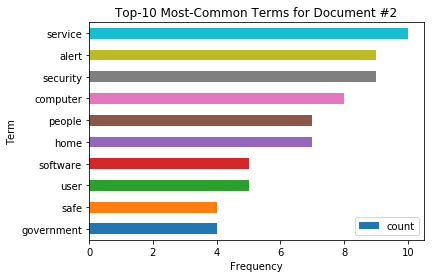

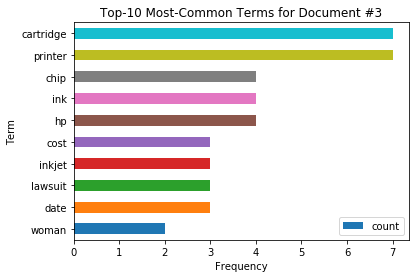

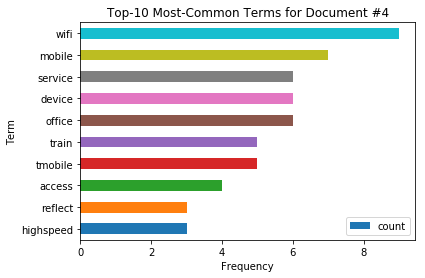

In [28]:
for i in range(5):
    word_counter = collections.Counter(raw_data['tokens'].iloc[i])
    most_common_df = frequencyDistToDataFrame(word_counter, 10)

    plotFrequencyDataFrame(most_common_df, title="Top-10 Most-Common Terms for Document #{}".format(i),
                           ylabel="Term")

In [29]:
for i in range(len(raw_data)):
    word_counter = collections.Counter(raw_data['tokens'].iloc[i])
    top_word_counts = word_counter.most_common(10)

    most_common_words = [word for word, count in top_word_counts]

    print("Doc-{:02d}: {}".format(i, most_common_words))

Doc-00: ['net', 'cafe', 'people', 'chinese', 'close', 'government', 'operate', 'china', 'authority', 'move']
Doc-01: ['mobile', 'network', '3g', 'technology', 'data', 'speed', 'hsdpa', 'operator', 'system', 'fast']
Doc-02: ['service', 'security', 'alert', 'computer', 'home', 'people', 'user', 'software', 'government', 'safe']
Doc-03: ['printer', 'cartridge', 'hp', 'ink', 'chip', 'date', 'lawsuit', 'inkjet', 'cost', 'woman']
Doc-04: ['wifi', 'mobile', 'office', 'device', 'service', 'tmobile', 'train', 'access', 'highspeed', 'reflect']
Doc-05: ['player', 'mp3', 'american', 'survey', 'compare', 'million', 'find', 'broadband', 'part', 'age']
Doc-06: ['phone', 'mobile', 'lose', 'backup', 'people', 'book', 'service', 'owner', 'year', 'address']
Doc-07: ['sky', 'telewest', 'box', 'subscriber', 'pvrs', 'record', 'video', 'recorder', 'pvr', 'digital']
Doc-08: ['program', 'criminal', 'virus', 'malicious', 'write', 'machine', 'change', 'infect', 'spyware', 'catch']
Doc-09: ['phone', 'technology',

On average, we see that most of the words in the top-ten from each document are to do with technology in some way, like "domain", "software", "digital", "site", "email", "virus", "computer", "text", "phone", "program", "wifi", etc.

It is interesting to see that there is a vast array of different words used in all of the articles, even though they all appear to be about the same generalised topic. 

However, we can also see how the documents can span multiple topic domains. For example, with Document #24, the most common words are:

`['format', 'dvd', 'technology', 'sony', 'film', 'bluray', 'studio', 'toshiba', 'disney', 'produce']`

It is unclear without context from the whole document whether this document is about technology or entertainment -  perhaps it is a mixture of both! We will discuss topic analysis in more detail later.

## Most-Common N-Grams

### Bigrams

First, we define a function for plotting our bigram data. We will reuse this as we explore our bigram data.

In [30]:
def plotBigrams(ngrams_data):
    # Get all the tokens for the corpus in a list.
    all_tokens_list = [token for tokens in ngrams_data for token in tokens]

    bigrams = nltk.bigrams(all_tokens_list)

    # Get the frequency of each term in the corpus and create a DataFrame from it.
    bigram_frequency = nltk.FreqDist(bigrams)
    bigrams_df = frequencyDistToDataFrame(bigram_frequency, 5)

    plotFrequencyDataFrame(bigrams_df, title="Top-10 Most-Common Bigrams for Entire Corpus",
                           xlabel="Frequency", ylabel="Bigram")

We tokenize our corpus content during n-gram analysis in a slighly different way than when analysing the corpus with other methods. Because n-grams can sometimes depend on the document context, we need to do the normalization step by step to make sure that we don't lose any potential information.

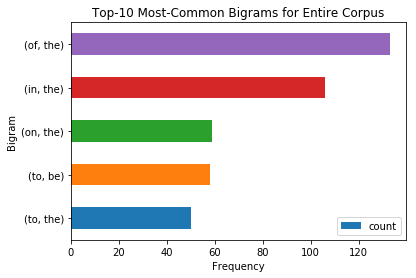

In [31]:
ngrams_data = raw_data['content'].copy()

ngrams_data = ngrams_data.apply(lambda x: x.split())
ngrams_data = ngrams_data.apply(decapitalize)
ngrams_data = ngrams_data.apply(remove_punctuation)

plotBigrams(ngrams_data)

This, unfortunately, doesn't give us very much data seeing as it is filled with stopwords. So we will remove the stop words from our data and see if we get better results.

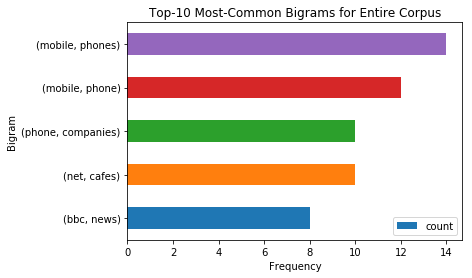

In [32]:
ngrams_data = ngrams_data.apply(remove_stop_words)

plotBigrams(ngrams_data)

This gives us far better results than before, but it is still flawed since "mobile phone" and "mobile phones" appear in the chart at the same time. This means that we should do lemmatization on the bigrams in order to get better information.

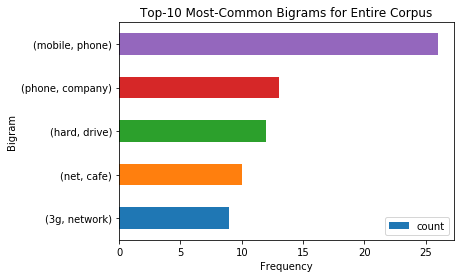

In [33]:
ngrams_data = ngrams_data.apply(lemmatize)

plotBigrams(ngrams_data)

These results are far better now. They give us even more information about the topics of the documents - all of the most-common bigrams are technology-related phrases.

### Trigrams

We will perform the same type of n-gram analysis now, except we will be considering n-grams of size 3, also known as *trigrams*.

In [34]:
def plotTrigrams(ngrams_data):
    # Get all the tokens for the corpus in a list.
    all_tokens_list = [token for tokens in ngrams_data for token in tokens]
    trigrams = nltk.ngrams(all_tokens_list, 3)

    # Get the frequency of each term in the corpus and create a DataFrame from it.
    trigram_frequency = nltk.FreqDist(trigrams)
    trigrams_df = frequencyDistToDataFrame(trigram_frequency, 5)

    plotFrequencyDataFrame(trigrams_df, title="Top-10 Most-Common Trigrams for Entire Corpus",
                           xlabel="Frequency", ylabel="Term")

    # Delete this to protect with code reuse.
    del all_tokens_list

We re-use the transformation functions that we used during our bigram analysis above.

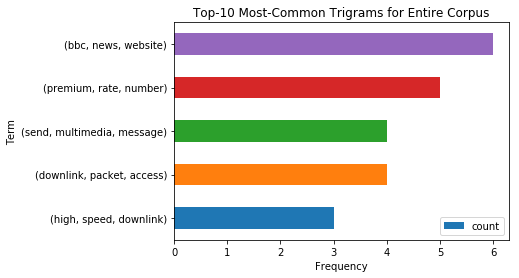

In [35]:
ngrams_data = raw_data['content'].copy()

ngrams_data = ngrams_data.apply(lambda x: x.split())
ngrams_data = ngrams_data.apply(decapitalize)
ngrams_data = ngrams_data.apply(remove_punctuation)
ngrams_data = ngrams_data.apply(lemmatize)
ngrams_data = ngrams_data.apply(remove_stop_words)

plotTrigrams(ngrams_data)

Just like with the bigram analysis, analysing the most-common trigrams has given us even more of an indication that the topic of the documents is to do with technology, due to the common trigram phrases that appear.

Another interesting piece of information that it gives is about the source of the documents. It would appear that at least some of the documents are articles that have been scraped from the BBC's website. This potentially-useful information was not available to use before doing trigram analysis, which shows how important n-gram analysis can be.

## Noun-Extraction

Now, we focus on extracting the noun tokens from the corpus. We will extract the nouns from each document using NLTK's part-of-speech (POS) tags. We will then add these noun tokens as a new column in our dataframe.

### Identify Noun Tokens

In [36]:
def getNounTokens(word_list):
    """
    Takes a list of words and returns a list of those words which have been tagged as nouns by NLTK.
    """
    nouns = []
    
    for word, pos in nltk.pos_tag(word_list):
        if pos[:2] == "NN":
            nouns.append(word)

    return nouns

In [37]:
raw_data['nouns'] = raw_data['tokens'].apply(getNounTokens)

raw_data.head()

title  \
id                                      
0    China net cafe culture crackdown   
1    Mobile networks seek turbo boost   
2   UK gets official virus alert site   
3       US woman sues over cartridges   
4    T-Mobile bets on 'pocket office'   

                                              content  \
id                                                      
0   \nChinese authorities closed 12,575 net cafes ...   
1   \nThird-generation mobile (3G) networks need t...   
2   \nA rapid alerting service that tells home com...   
3   \nA US woman is suing Hewlett Packard (HP), sa...   
4   \nT-Mobile has launched its latest "pocket off...   

                                               tokens  \
id                                                      
0   [chinese, authority, close, net, cafe, closing...   
1   [thirdgeneration, mobile, 3g, network, fast, d...   
2   [rapid, alerting, service, home, computer, use...   
3   [woman, sue, hewlett, packard, hp, printer, in...   
4   [tmobile, launch, late, pocket, office, thirdg...   

                                                nouns  
id                                                     
0   [authority, cafe, month, country, government, ...  
1   [thirdgeneration, mobile, network, surf, move,...  
2   [service, home, computer, security, problem, l...  
3   [woman, sue, printer, ink, cartridge, program,...  
4   [launch, pocket, office, thirdgeneration, devi...

### Save Data Frame

We will now save our updated dataframe to a CSV file called *H1_tokens_data.csv*.

In [38]:
# Save the dataframe to a CSV file.
raw_data.to_csv(output("H1_tokens_data.csv"), sep=',', index=None)

del raw_data

To show that our dataframe was written to a CSV file correctly, we will re-read it again. However, because we had lists of strings in our dataframe, we will need to do some parsing to ensure that they are read back into a dataframe in the correct format.

In [39]:
def convertStringList(stringList):
    """
    Takes a string representation of a list of strings, returns the actual list of strings object.
    e.g. "['one', 'two']" -> ["one", "two"]
    """
    # Removes all of the apostrophes and brackets.
    regex = r'\w+'
    regex_tokenizer = nltk.RegexpTokenizer(regex)
    
    # Create and return a list of strings from the string representation of a list of strings.
    return regex_tokenizer.tokenize(stringList)

In [40]:
# Reload dataframe from newly-created file.
raw_data = pd.read_csv(output("H1_tokens_data.csv"))

raw_data['nouns'] = raw_data['nouns'].apply(convertStringList)
raw_data['tokens'] = raw_data['tokens'].apply(convertStringList)

raw_data.head()

title  \
0   China net cafe culture crackdown   
1   Mobile networks seek turbo boost   
2  UK gets official virus alert site   
3      US woman sues over cartridges   
4   T-Mobile bets on 'pocket office'   

                                             content  \
0  \r\nChinese authorities closed 12,575 net cafe...   
1  \r\nThird-generation mobile (3G) networks need...   
2  \r\nA rapid alerting service that tells home c...   
3  \r\nA US woman is suing Hewlett Packard (HP), ...   
4  \r\nT-Mobile has launched its latest "pocket o...   

                                              tokens  \
0  [chinese, authority, close, net, cafe, closing...   
1  [thirdgeneration, mobile, 3g, network, fast, d...   
2  [rapid, alerting, service, home, computer, use...   
3  [woman, sue, hewlett, packard, hp, printer, in...   
4  [tmobile, launch, late, pocket, office, thirdg...   

                                               nouns  
0  [authority, cafe, month, country, government, ...  
1  [thirdgeneration, mobile, network, surf, move,...  
2  [service, home, computer, security, problem, l...  
3  [woman, sue, printer, ink, cartridge, program,...  
4  [launch, pocket, office, thirdgeneration, devi...

### Most-Common Nouns

Now we want to take a look at the most-common nouns in each document, similar to how we looked at the most-common tokens in each document in part 6.

#### Across Entire Corpus

We define a function that will create a list of all nouns in the dataframe and then plot a bar chart of the resulting frequency distribution.

In [41]:
def getAllNouns(df):
    """
    Convert the nouns column in a dataframe into a list of strings of every 
    nouns in the nouns column.
    """
    return [noun for nouns in df['nouns'] for noun in nouns]

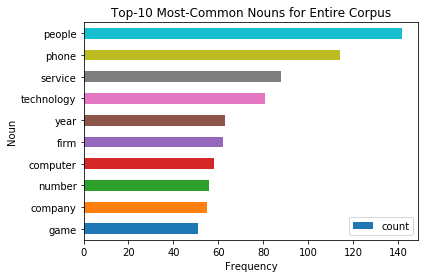

In [42]:
all_nouns = getAllNouns(raw_data)

# Get the frequency of each noun in the corpus and create a DataFrame from it.
nouns_counter = collections.Counter(all_nouns)
most_common_nouns_df = frequencyDistToDataFrame(nouns_counter, 10)

plotFrequencyDataFrame(most_common_nouns_df, title="Top-10 Most-Common Nouns for Entire Corpus",
                       ylabel="Noun")

# Delete these to protect code reuse.
del most_common_nouns_df, all_nouns

We see that our bar chart of the most-common nouns is very similar to the bar chart we had for the most-common words in the entire corprus. Let's calculate just how much overlap there is between the two:

In [43]:
all_nouns = getAllNouns(raw_data)
all_tokens = getAllTokens(raw_data)

nouns_counter = collections.Counter(all_nouns)
tokens_counter = collections.Counter(all_tokens)

top_nouns = set([noun for noun, count in nouns_counter.most_common(10)])
top_tokens = set([token for token, count in tokens_counter.most_common(10)])

overlap = top_nouns.intersection(top_tokens)

print("There are {} words in both top-ten lists: {}".format(len(overlap), overlap))

There are 8 words in both top-ten lists: {'technology', 'firm', 'number', 'people', 'year', 'computer', 'service', 'phone'}


We see that counting the top-ten nouns gives us 80% similar results to counting the top-ten tokens, which shows us that the frequency of words is biased based on that words type. In other words, nouns are far more likely in a document than verbs, adverbs, etc., especially after we remove stop words from the text.

#### Per Document

Like in part 6, we print out the list of top-ten nouns for each document, but only plot a bar chart of the top-ten most-common nouns for the first five documents.

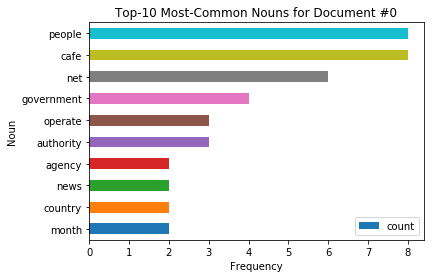

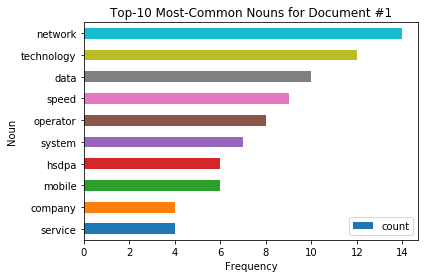

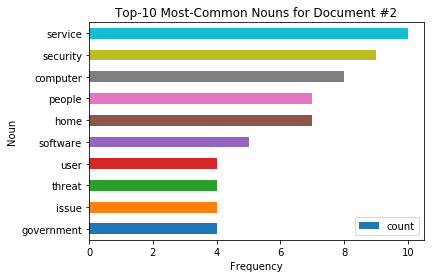

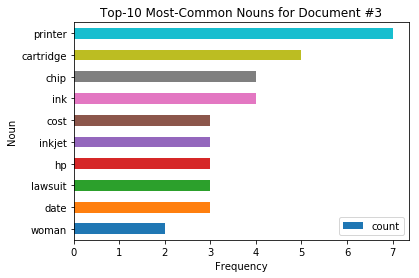

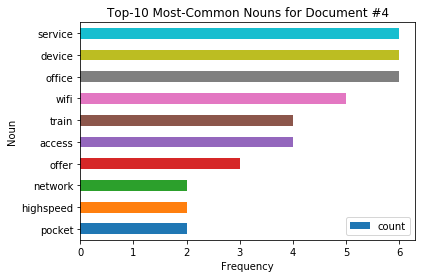

In [44]:
for i in range(5):
    
    # Get the frequency of each noun in the i-th document and create a DataFrame from it.
    nouns_counter = collections.Counter(raw_data['nouns'][i])

    most_common_nouns_df = frequencyDistToDataFrame(nouns_counter, 10)

    plotFrequencyDataFrame(most_common_nouns_df, 
                           title="Top-10 Most-Common Nouns for Document #{}".format(i), ylabel="Noun")

In [45]:
for i in range(len(raw_data)):
    
    # Get the frequency of each noun in the i-th document and create a DataFrame from it.
    nouns_counter = collections.Counter(raw_data['nouns'][i])
    most_common_nouns = [noun for noun, count in nouns_counter.most_common(10)]

    print("Doc-{:02d}: {}".format(i, most_common_nouns))

Doc-00: ['cafe', 'people', 'net', 'government', 'authority', 'operate', 'month', 'country', 'news', 'agency']
Doc-01: ['network', 'technology', 'data', 'speed', 'operator', 'system', 'mobile', 'hsdpa', 'service', 'company']
Doc-02: ['service', 'security', 'computer', 'home', 'people', 'software', 'government', 'issue', 'threat', 'user']
Doc-03: ['printer', 'cartridge', 'ink', 'chip', 'date', 'lawsuit', 'hp', 'inkjet', 'cost', 'woman']
Doc-04: ['office', 'device', 'service', 'wifi', 'access', 'train', 'offer', 'pocket', 'highspeed', 'network']
Doc-05: ['player', 'mp3', 'survey', 'broadband', 'part', 'compare', 'age', 'people', 'life', 'project']
Doc-06: ['phone', 'mobile', 'people', 'book', 'backup', 'service', 'owner', 'year', 'intervoice', 'address']
Doc-07: ['box', 'sky', 'subscriber', 'pvrs', 'record', 'pvr', 'tv', 'version', 'subscription', 'cable']
Doc-08: ['program', 'virus', 'machine', 'change', 'technology', 'people', 'data', 'end', 'firm', 'network']
Doc-09: ['phone', 'technol

Again, on a quick glance we see that these results are very similar to the results we had for the top-ten tokens per document. We investigate just how similar these results are, and calculate the overlap percentage using the formula:

$$ overlap\;percentage = 100\times\frac{N \cap T}{10 \times |D|} $$

Where N is the top-10 list for nouns; T is the same, but for tokens; and D is the set of documents.

We note that this is a variant on *Jaccard Similarity*, which we will discuss in more detail later.

In [46]:
total_overlap = 0
for i in range(len(raw_data)):
    nouns_counter = collections.Counter(raw_data['nouns'].iloc[i])
    tokens_counter = collections.Counter(raw_data['tokens'].iloc[i])

    top_nouns = set([noun for noun, count in nouns_counter.most_common(10)])
    top_tokens = set([token for token, count in tokens_counter.most_common(10)])

    overlap = top_nouns.intersection(top_tokens)
    total_overlap += len(overlap)

    print("Doc-{:02d} Overlap ({}): {}".format(i, len(overlap), overlap))
    
overlap_percent = 100*total_overlap/(10 * len(raw_data))
overlap_label = "The total overlap is {} words from {} documents ({:.2f}%)"

print(overlap_label.format(total_overlap, len(raw_data), overlap_percent))

Doc-00 Overlap (6): {'people', 'government', 'authority', 'cafe', 'operate', 'net'}
Doc-01 Overlap (8): {'technology', 'data', 'system', 'operator', 'speed', 'mobile', 'network', 'hsdpa'}
Doc-02 Overlap (8): {'people', 'government', 'user', 'computer', 'home', 'software', 'service', 'security'}
Doc-03 Overlap (10): {'ink', 'hp', 'printer', 'chip', 'cost', 'lawsuit', 'inkjet', 'date', 'woman', 'cartridge'}
Doc-04 Overlap (7): {'office', 'highspeed', 'train', 'wifi', 'device', 'access', 'service'}
Doc-05 Overlap (7): {'age', 'player', 'compare', 'survey', 'mp3', 'part', 'broadband'}
Doc-06 Overlap (9): {'people', 'address', 'book', 'year', 'backup', 'owner', 'mobile', 'service', 'phone'}
Doc-07 Overlap (6): {'pvrs', 'sky', 'subscriber', 'record', 'box', 'pvr'}
Doc-08 Overlap (4): {'virus', 'machine', 'program', 'change'}
Doc-09 Overlap (6): {'technology', 'network', 'gadget', 'operator', 'service', 'phone'}
Doc-10 Overlap (8): {'pc', 'trotter', 'magazine', 'design', 'product', 'award', '

This shows us that the top-ten lists for both nouns and tokens are very similar to each other. This shows us that nouns are the most frequent type of word to appear in a document. Again, we see that most of the nouns are related to technology in some way.

## Assign a Topic to the Documents

Now, we move onto trying to classify the corpus of documents into a specific topic. We have five topics to choose from: business, entertainment, politics, sport and technology. We will discuss a number of ideas with which to try and classify the documents, including:
* Word Definitions-Distance Using WordNet
* Topic Name Frequency
* Lexicon-Based Distance

We define our list of topics now, we will be using this often later.

In [47]:
TOPICS = ['business', 'entertainment', 'politics', 'sport', 'technology']

### Re-Normalizing the Corpus

We reload the corpus here with a different form of normalization. Firstly, we want to keep the title and the content of the article together, since the article titles can help when determining the topic of a document. 

In [48]:
whole_text = raw_data['title'] + raw_data['content']
whole_text = normalize_text(whole_text)

### Identifying Most-Important Words

We will use the TF-IDF Vectorizer that is provided in the SkLearn modules. 

TF-IDF stands for Term Frequency-Inverse Document Frequency. It is defined as follows:
$$ TFIDF(term) = TF * IDF $$

$$ TF(term, document) = \frac{frequency(term)}{length(document)} $$

$$ IDF(term) = \frac{number\;of\;documents\;containing\;term}{number\;of\;documents\;in\;corpus} $$

Words that are more common will have a higher TF value. Words that are more important (that is, they are characteristic to only a small subset of documents), will have a higher IDF value. TFIDF balances the two in order to find the most-important words in the corpus.


When we do the TF-IDF Vectorization, we normalize the results by the length of the documents and we include both unigrams, bigrams and trigrams in our analysis.

In [49]:
# Combine each document's whole text content into a string.
documents = [" ".join(token) for token in whole_text]

# Normalize the TFIDF scores by the length of each document, including uni-, bi- and tri-grams.
tfidf_vectorizer = TfidfVectorizer(norm='l2', ngram_range=(1,3))

# Perform the TFIDF calculations.
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

doc_label = "Doc-{:02d}"
doc_index = [doc_label.format(i) for i in range(len(raw_data))]
tfidf_data = pd.DataFrame(tfidf_matrix.toarray(),
                        columns=[tfidf_vectorizer.get_feature_names()],
                        index=doc_index)

tfidf_data.head()

10th 10th anniversary 10th anniversary pc 12month 12month contract  \
Doc-00  0.0              0.0                 0.0     0.0              0.0   
Doc-01  0.0              0.0                 0.0     0.0              0.0   
Doc-02  0.0              0.0                 0.0     0.0              0.0   
Doc-03  0.0              0.0                 0.0     0.0              0.0   
Doc-04  0.0              0.0                 0.0     0.0              0.0   

       12month contract broadband 133m 133m text 133m text message    14mbps  \
Doc-00                        0.0  0.0       0.0               0.0  0.000000   
Doc-01                        0.0  0.0       0.0               0.0  0.023314   
Doc-02                        0.0  0.0       0.0               0.0  0.000000   
Doc-03                        0.0  0.0       0.0               0.0  0.000000   
Doc-04                        0.0  0.0       0.0               0.0  0.000000   

             ...       zombie network spy zone zone make  \
Doc-00       ...                      0.0  0.0       0.0   
Doc-01       ...                      0.0  0.0       0.0   
Doc-02       ...                      0.0  0.0       0.0   
Doc-03       ...                      0.0  0.0       0.0   
Doc-04       ...                      0.0  0.0       0.0   

       zone make traditional zonealarm zonealarm tool zonealarm tool prevent  \
Doc-00                   0.0       0.0            0.0                    0.0   
Doc-01                   0.0       0.0            0.0                    0.0   
Doc-02                   0.0       0.0            0.0                    0.0   
Doc-03                   0.0       0.0            0.0                    0.0   
Doc-04                   0.0       0.0            0.0                    0.0   

       zoom zoom drive zoom drive sale  
Doc-00  0.0        0.0             0.0  
Doc-01  0.0        0.0             0.0  
Doc-02  0.0        0.0             0.0  
Doc-03  0.0        0.0             0.0  
Doc-04  0.0        0.0             0.0  

[5 rows x 24695 columns]

We see that the TF-IDF dataframe is full of zero values, this is known as being very *sparse*. This is not surprising though, seeing as the TF-IDF value will be zero is the term doesn't appear in the document at all.


We get the average of the TF-IDF data across all documents to determine the most-important words in the entire corpus.

In [50]:
tfidf_mean = tfidf_data.mean(axis=0)
most_important_words = list(tfidf_mean.nlargest(10).index)
most_important_words

[('phone',),
 ('people',),
 ('mobile',),
 ('game',),
 ('service',),
 ('technology',),
 ('computer',),
 ('player',),
 ('firm',),
 ('net',)]

### Evaluating WordNet as a Similarity Measure

WordNet is a lexical database, grouping words into sets of synonyms called synsets. It records relations between words in a tree structure. We can use the distance between nodes in this tree as to measure how similar words are to each other. It is often used in Text Analytics.

We define a function for getting the WordNet distance between two words.

In [51]:
def wordNetSimilarity(term, topic):    
    term_synset = wordnet.synsets(term, 'n')
    topic_synset = wordnet.synsets(topic, 'n')
    
    return max(sterm.path_similarity(stopic) for sterm in term_synset for stopic in topic_synset)

We test to see how applicable this similarity measure is for our topics, with a selction of words from the most important words list.

In [52]:
wordnet_test = {}
test_word = 'computer'

for topic in TOPICS:
    similarity = wordNetSimilarity(test_word, topic)
    print("Similarity between the topic '{}' and '{}' = {}".format(topic, test_word, similarity))

Similarity between the topic 'business' and 'computer' = 0.1
Similarity between the topic 'entertainment' and 'computer' = 0.07692307692307693
Similarity between the topic 'politics' and 'computer' = 0.1
Similarity between the topic 'sport' and 'computer' = 0.25
Similarity between the topic 'technology' and 'computer' = 0.07692307692307693


We see that this similarity metric is not very good at classifying words into a topic. In fact, technology would be the topic that is most-similar to the word 'computer' and yet WordNet computes it as being the least-similar!

This may just be a once-off so we test for some other words in the most-important word list.

In [53]:
test_words = ['net', 'service', 'mobile', 'phone']
topic_class = {}

for word in test_words:
    most_similar_topic = None
    max_similarity = 0
    
    for topic in TOPICS:
        similarity = wordNetSimilarity(word, topic)
        
        if similarity > max_similarity:
            most_similar_topic = topic
            max_similarity = similarity
            
    topic_class[word] = most_similar_topic
    
topic_class

{'mobile': 'sport', 'net': 'sport', 'phone': 'politics', 'service': 'business'}

We see that a WordNet provides very poor results when matching words to one of the topics in our list. Therefore, we won't be using it in our topic-classifying model.

### Topic Name Frequency

Another way of determining which topic is more prevalent in the corpus is to calculate the number of times the topical word actually appears in the text. We do this below:

In [54]:
all_words = [word for words in whole_text for word in words]
topic_frequency = {}

for topic in TOPICS:
    topic_frequency[topic] = all_words.count(topic)
    
topic_frequency

{'business': 10,
 'entertainment': 11,
 'politics': 0,
 'sport': 5,
 'technology': 82}

We can see that this strategy corresponds with our previous findings: that technology is the topic of most of the documents. However, this strategy isn't without its limits. For example, it a document refers to 'tech' throughout, instead of 'technology', it won't be counted.

This means that we should consider building a dictionary of words that correspond with technology or technological subjects. We apply this now to all of the topics. This is known as a *lexicon-based approach*.

### Lexicon-Based Approach

Firstly, we define a list of words that are closely related to each of the topics.

In [55]:
TOPIC_LEXICON = {
    
    'technology' : [
        'technology', 'tech', 'computer', 'pc', 'hardware', 'software', 'mobile', 'code'
        'phone', 'internet', 'site', 'network','domain', 'email', 'printer', 'spam', 'data', 
        'digital', 'virtual', 'byte', 'browser', 'framework',
    ],
    
    'sport' : [
        'sport', 'sports', 'field', 'pitch', 'fans', 'ball', 'soccer', 'football', 'tennis',
        'game', 'event', 'match', 'final', 'hurling', 'goal', 'active', 'exercise', 'activity',
        'rugby', 'boxing', 'gymnastics', 'hockey', 'olympics', 'climbing', 'baseball', 'skiing'
    ],
    
    'politics' : [
        'politics', 'politician', 'vote', 'election', 'referendum', 'td', 'representative',
        'senator', 'dail', 'president', 'congress', 'political', 'democracy', 'cabinet',
        'parliament', 'consitution', 'prime', 'minister', 'secretary', 'government', 'state',
    ],
    
    'entertainment' : [
        'entertainment', 'tv', 'television', 'show', 'viewer', 'movie', 'musical', 'artist',
        'presenter', 'broadcast', 'media', 'stage', 'theater', 'crowd', 'event', 'audience', 
        'cinema', 'bbc', 'rte', 'cnn', 'nbc', 'performance', 'culture'
    ],
    
    'business' : [
        'business', 'investment', 'investor', 'stock', 'market', 'corporate', 'sales', 'money',
        'ceo', 'chairman', 'board', 'revenue', 'venture', 'capitalism', 'company', 'profit',
        'manager', 'employee', 'finance', 'corporation', 'resume', 'networking'
    ]
    
}

Now we use a variant of Jaccard similarity to measure the overlap between a document's contents and the topic lexicon. We define some functions to help us achieve this:

In [56]:
def topicJaccardScore(document, topic):
    topic_words = TOPIC_LEXICON[topic]
    
    jaccard_score = len([True for token in document if token in topic_words])
    
    return jaccard_score


def topicProbabilities(document):
    jaccard_scores = {}
    for topic in TOPICS:
        jaccard_scores[topic] = topicJaccardScore(document, topic)
        
    # Normalise the probabilities so they sum to 1.
    total = sum(jaccard_scores.values())
    probabilities = {k: v / total for k, v in jaccard_scores.items()}
    
    return probabilities

Let's try this out on the first document:

In [57]:
title = raw_data['title'].iloc[0]
topics = topicProbabilities(whole_text.iloc[0])

print("Doc-0 title = {}".format(title))
print(topics)

Doc-0 title = China net cafe culture crackdown
{'business': 0.0, 'entertainment': 0.07692307692307693, 'politics': 0.3076923076923077, 'sport': 0.07692307692307693, 'technology': 0.5384615384615384}


We can see that this article is definitely about technology, since it refers to "net cafe culture", but also includes a little bit of politics, since it is about the Chinese government. So our model does very well in predicting the topic.

We now apply this model to the whole corpus and then to each of the documents individually.

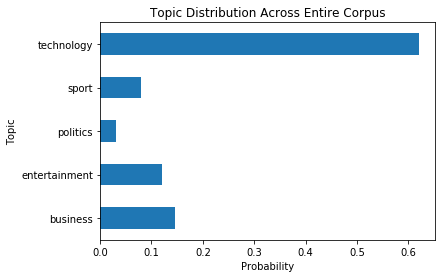

In [58]:
all_words = [word for document in whole_text for word in document]

topics = topicProbabilities(all_words)

corpus_topic_df =  pd.DataFrame([topics]).T

axis = corpus_topic_df.plot.barh(legend=None)

axis.set_title("Topic Distribution Across Entire Corpus")
axis.set_xlabel("Probability")
axis.set_ylabel("Topic")

plt.show()

We can clearly see here that, as we have mentioned throughout, technology is the main topic of the entire corpus. We look at classifying each document individually now:

In [59]:
print("Document \t Topic \t Title")

for i in range(len(whole_text)):
    title = raw_data['title'].iloc[i]
    topics = topicProbabilities(whole_text.iloc[i])
    topic = max(topics, key=lambda k: topics[k])
    
    print("Doc-{:02d} \t {} \t {}".format(i, topic, title))

Document 	 Topic 	 Title
Doc-00 	 technology 	 China net cafe culture crackdown
Doc-01 	 technology 	 Mobile networks seek turbo boost
Doc-02 	 technology 	 UK gets official virus alert site
Doc-03 	 technology 	 US woman sues over cartridges
Doc-04 	 technology 	 T-Mobile bets on 'pocket office'
Doc-05 	 technology 	 Millions buy MP3 players in US
Doc-06 	 technology 	 'Friends fear' with lost mobiles
Doc-07 	 entertainment 	 Telewest to challenge Sky Plus
Doc-08 	 technology 	 Rich pickings for hi-tech thieves
Doc-09 	 technology 	 The future in your pocket
Doc-10 	 technology 	 Sony wares win innovation award
Doc-11 	 sport 	 Portable PlayStation ready to go
Doc-12 	 technology 	 BT offers free net phone calls
Doc-13 	 technology 	 Microsoft gets the blogging bug
Doc-14 	 technology 	 New Year's texting breaks record
Doc-15 	 business 	 DS aims to touch gamers
Doc-16 	 technology 	 Freeze on anti-spam campaign
Doc-17 	 technology 	 'Brainwave' cap controls computer
Doc-18 	 sport 	 

The vast majority of documents are predicted to be about technology. Note that there are a number of documents about gaming and esports (mentioning PSPs, Xbox, Nintendo DS, etc.). It is interesting to see that these documents are classified as being about sports rather than technology. Perhaps this is indicative of the growing 'e-sports' industry.

While some of our documents have been classified as being slight more in common with a different topic, they do still have a lot in common with technology. Therefore, we have shown that the overall topic of the corpus is **technology**.

## Identify the Special Document

We now turn our attention towards trying to find the outlier document in the corpus. It is likely that this document is the one that has the least to do with technology and the most to do with another topic.

### Re-Normalizing the Corpus

We reload the corpus here with a different form of normalization. As with the topical analysis, we want to keep the title and the content of the article together. However, we also specify that when normalizing the text content, we don't want to do any transformations. Specifically, we don't remove the stop words and we don't do any lemmatization. This is because we want to keep the textual data as close to the raw content as possible.

In [60]:
corpus_content = raw_data['title'] + raw_data['content']
corpus_content = normalize_text(corpus_content, keep_stop_words=True, lemmatization=False)

### Principal Component Analysis

We use PCA to reduce the number of dimensions in the data. Currently, we have a lot of columns, one for every unigram, bigram and trigram.

In [61]:
print("Number of dimensions in TFIDF dataframe: {}".format(len(tfidf_data.columns)))

Number of dimensions in TFIDF dataframe: 24695


If we needed to save computation time, we could use PCA to reduce the number of dimensions in our data and thus, columns in our dataframe.

We use PCA with `n_components=2` because it's easiest to visualize because we can plot the first component against the second on the x-y plane. In practice, we would take a higher value of n since we are losing a lot of data by reducing the dimensions to just two. However, we include it here to show that it could be used in a small number of cases to detect an outlier.

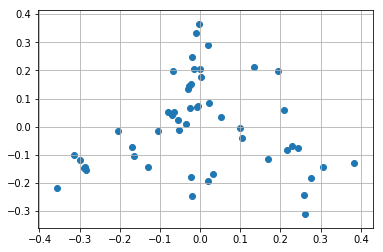

In [62]:
pca = PCA(n_components=2)

document_vectors = [tfidf_data.iloc[i].values for i in range(len(tfidf_data))]
decomposed_document_vectors = pca.fit_transform(document_vectors)

plt.scatter(decomposed_document_vectors[:,0], decomposed_document_vectors[:,1])

plt.grid()
plt.show()

We can see that there is a little bit of variation between different documents in our corpus. Note, however, that the range of the axis on our visualization is very small. Because of this, and the clustering of the points, we conclude that there is no document that is far enough away from the others to be considered a total outlier through PCA(n=2) analysis alone.

This is unsurprising, given that we are losing lots of information by reducing the number of dimensions from over 24,000 to just 2 all at once.

### Distance Measurement

There are a number of different measures that we could use to calculate the distance between documents in the corpus. For example, we could use *cosine distance* or *Euclidean distance*. 

For our analysis, we pick cosine distance. This is because it is considered more reliable than Euclidean distance, given it doesn't depend on the length of the document vectors, but only the angle between them.

It is very difficult to find the distance between words. One way of doing this would be through *Levenshtein Distance*. However, it is much easier if we can convert our text to a numeric form. For this, we will reuse the TFIDFVectorizer that we used before.

In [63]:
# Combine each document's whole text content into a string.
documents = [" ".join(token) for token in corpus_content]

# Normalize the TFIDF scores by the length of each document, including uni-, bi- and tri-grams.
tfidf_vectorizer = TfidfVectorizer(norm='l2', ngram_range=(1,3))

# Perform the TFIDF calculations.
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

# Calculate cosine distance based on the TFIDF data.
pairwise_cosine_distance = sklearn.metrics.pairwise_distances(tfidf_matrix, metric='cosine')

# The outlier will have the biggest total distance from all other documents.
total_cosine_distance = [sum(row) for row in pairwise_cosine_distance]
outlier = np.argmax(total_cosine_distance)

print("The outlier document is Document #{}.".format(outlier))

The outlier document is Document #23.


Let's look at the content of that document:

In [64]:
title = raw_data['title'].iloc[outlier]
content = raw_data['content'].iloc[outlier]

print("title = {}".format(title))
print("content = {}".format(content))

title = US show sued for rat-eating stunt
content = 
A US TV network is being sued for $2.5m (£1.3m) by a viewer who says he was disgusted by watching contestants eat dead rats in a stunt show.

Austin Aitken is taking action against NBC over its programme Fear Factor. He said watching the show caused his blood pressure to rise so high that he became dizzy and light-headed. The legal assistant said NBC was "sending the wrong message to viewers that cash can make or have people do just about anything beyond reasoning". The hand-written, four-page lawsuit said: "To have the individuals on the show eat and drink dead rats was crazy and from a viewer's point of view made me throw-up as well as another in the house at the same time." Mr Aitken, who lives in Cleveland, said that after becoming light-headed, he ran towards the bedroom and knocked his head in a doorway. A spokesman for NBC said it had no comment on the lawsuit, but confirmed the stunt show did feature a rat-eating scene in New

As we can see, we have correctly identified the outlier document. While all the other documents in the corpus are related to technology in some way, this document is better aligned with the topic of entertainment.

## Extra: Model Generalisation

Want to make sure that our model generalises well to real-world examples outside of the trained corpus, so we test it out on an article that we scrape from the Irish Times website.

In [65]:
def scrapeIrishTimesArticle(url):
    # Download the page HTML content and parse with Beautiful Soup.
    page = requests.get(url)
    soup = bs4.BeautifulSoup(page.text, "html.parser")
    
    title = soup.title.string
    
    content = " ".join(paragraph.get_text() 
                       for paragraph in soup.article.find_all("p", attrs={"class": "no_name"}))


    return title, content

In [66]:
article_url = "https://www.irishtimes.com/news/world/brexit/taoiseach-should-refuse-to-compromise-on-brexit-voters-say-1.3666980"

article_title, article_content = scrapeIrishTimesArticle(article_url)

# Convert the article content to a Pandas series so we can apply our normalisation functions.
document = normalize_text(pd.Series(article_content))

# Predict the most-likely topic.
probabilities = topicProbabilities(document.iloc[0])
topic = max(probabilities, key=lambda k: probabilities[k])

print("Article = {}".format(article_title))
print("Topic = {}".format(topic))

print("\nContent =")
print(article_content[:250], "...")

Article = Taoiseach should refuse to compromise on Brexit, voters say
Topic = politics

Content =
An overwhelming majority of voters believe that Taoiseach Leo Varadkar should stick to his position on Brexit and should not compromise to achieve a deal with the UK, the latest Irish Times/Ipsos MRBI opinion poll has found. The poll also shows that  ...


We see that our topic-prediciting model generalises well to an unseen document, correctly predicting that it is about politics.